In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl


In [4]:
from matplotlib.ticker import MaxNLocator

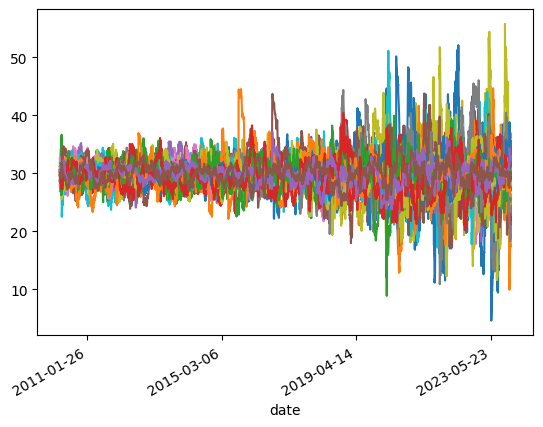

In [7]:
min_val = np.inf
max_val = -np.inf
high_var = ['COKE']
# high_var = []
c = 30
for file in os.listdir('stockandETF'):
    if file.endswith('.csv'):
        # Load asset price data
        name = file.split('.')[0]
        if name in high_var:
            continue
        df = pd.read_csv(f'stockandETF\{file}', index_col=0)
        df.index = pd.to_datetime(df.index)
        stock = df.columns[0]
        etf = df.columns[1]
        
        betas = []
        chunk_size = 60
       
        for start in range(0, len(df) - chunk_size):
            end = start + chunk_size
            X= df.iloc[start:end, 1].values.reshape(-1, 1)  # ETF
            y = df.iloc[start:end, 0].values  # Stock
            beta = sm.OLS(y, X).fit().params[0]
            betas.append(beta)
        data =df[60::].copy()
        data['beta'] = betas
        data['value'] = data.iloc[::,0] - data['beta'] * data.iloc[::, 1]
        # ax = data['value'].plot(label=name)
        # ax.xaxis.set_major_locator(MaxNLocator(5))
        # if data['value'].min() < min_val:
        #     print(name, data['value'].min())
        min_val = min(data['value'].min(), min_val)
        max_val = max(data['value'].max(), max_val)
        # print(f'Highest deviation for {name} is {data["value"].abs().max()}')
        data['price'] = data['value']+c
        ax = data['price'].plot(label=name)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        data.to_csv(f'beta\{name}.csv')
# print(min_val, max_val)


In [53]:
data = None
for file in os.listdir('beta'):
    df = pd.read_csv(f'beta\{file}')
    stock_name = df.columns[1]
    df = df[['date','price']]
    df = df.rename(columns={'price': stock_name})
    if data is None:
        data = df
    else:
        data = pd.merge(data, df, on='date', how='left')
data = data.set_index('date')
data.index = pd.to_datetime(data.index)

In [35]:
import matplotlib.dates as mdates
from datetime import datetime

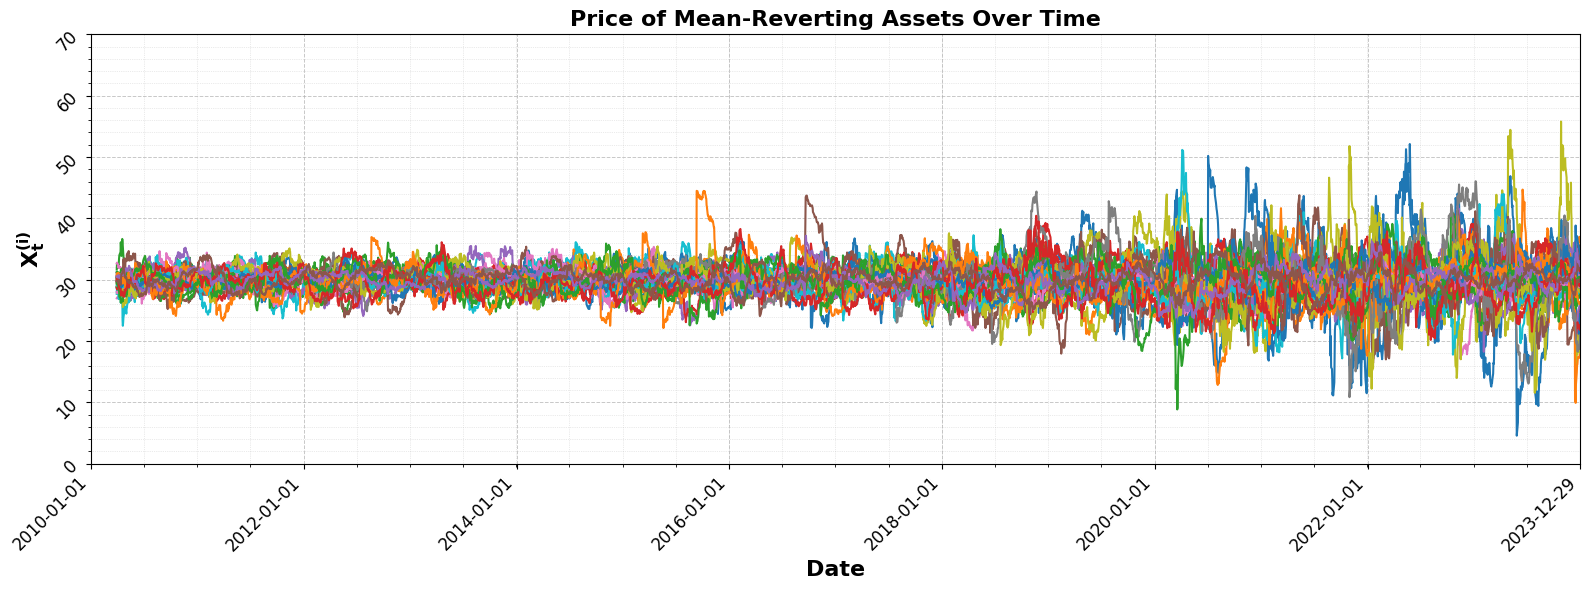

In [73]:
# Plot the data with customizations
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(data)
# Customize the plot
ax.set_xlabel('Date', fontsize=16, fontweight='bold')
ax.set_ylabel('$\mathbf{X^{(i)}_t}$', fontsize=16, fontweight='bold')
ax.set_title('Price of Mean-Reverting Assets Over Time', fontsize=16, fontweight='bold')
ax.set_ylim(0, 70)
ax.set_xlim(datetime(2010, 1, 1), datetime(2023, 12, 31))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.minorticks_on()  # Turn on minor gridlines
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
current_ticks = ax.get_xticks()
last_date = data.index[-1]
ax.set_xlim([data.index[0], last_date])
new_ticks = list(current_ticks)[:-1] + [mdates.date2num(last_date)]
ax.set_xticks(new_ticks)
ax.tick_params(axis='both', labelsize=12, labelrotation=45)
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()
